# `0.` IMPORTING REQUIRED LIBs

In [1]:
# base libariries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import shapiro

# preprocessing libariries
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

# statistics 
from statsmodels.api import OLS
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# splitting helper
from sklearn.model_selection import train_test_split

# models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# evaluation metric
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score

# warnings
import warnings
warnings.filterwarnings("ignore")

# `1.` HELPER FUNCTIONS

In [2]:
# function to get the updated numerical columns
def get_numeric(features_df):
    return list(set([c for c in features_df.columns if np.issubdtype(features_df[c].dtype, np.number)]) - set(['HasCrCard', 'IsActiveMember']))

#### `1.00` Handling nulls >> No Nulls in this data

In [3]:
def handle_nulls(features_df, cols_threshold, rows_threshold):
    # data shape
    observations_num = features_df.shape[0]

    # getting count of nulls in columns
    cols_nulls_count = features_df.isna().sum(axis=0).reset_index().rename(columns={0: 'null_counts'})
    nulls_cols = cols_nulls_count[cols_nulls_count['null_counts']>0]

    # handling them
    cols_to_be_dropped = set(nulls_cols[nulls_cols['null_counts']/observations_num > cols_threshold]['index'])
    rows_to_be_dropped = set(nulls_cols[nulls_cols['null_counts']/observations_num < rows_threshold]['index'])
    cols_to_be_imputed = set(nulls_cols['index']) - cols_to_be_dropped - rows_to_be_dropped

    # dictionary 
    final = {'cols_to_be_dropped': list(cols_to_be_dropped), 
             'rows_to_be_dropped': list(rows_to_be_dropped),
             'cols_to_be_imputed': list(cols_to_be_imputed)}

    return final

#### `1.01` Handling duplicates >> >> No Duplicates in this data

In [4]:
def handle_duplicates(features_df, dup_threshold):
    # data shape
    observations_num = features_df.shape[0]

    cols_to_be_dropped = []
    for c in features_df.columns:
        if (features_df[c].value_counts()/observations_num > dup_threshold).sum():
            cols_to_be_dropped.append(c)
            
    return cols_to_be_dropped

#### `1.02` Handling outliers

In [5]:
def handle_outliers(features_df, out_threshold):
    numeric = get_numeric(features_df) 
    Q1 = np.quantile(features_df[numeric], q=0.25, method='midpoint', axis=0)
    Q3 = np.quantile(features_df[numeric], q=0.75, method='midpoint', axis=0)

    IQR = Q3 - Q1
    upper_bound = Q3 + out_threshold * IQR
    lower_bound = Q1 - out_threshold * IQR

    return lower_bound, upper_bound

In [6]:
def outliers_clamping(features_df, lower_bound, upper_bound):
    numeric = get_numeric(features_df)
    num_of_features = numeric.__len__()
    
    for i in range(num_of_features):
        before = features_df[numeric[i]]
        features_df[numeric[i]] = np.where(features_df[numeric[i]] <= upper_bound[i], features_df[numeric[i]], upper_bound[i])
        features_df[numeric[i]] = np.where(features_df[numeric[i]] >= lower_bound[i], features_df[numeric[i]], lower_bound[i])
        after = features_df[numeric[i]]
        print(f'shape = {features_df.shape[0]}, total matched {(before == after).sum()}')

#### `1.03` Handling skewness

In [7]:
def skewness(features_df):
    # data shape
    observations_num = features_df.shape[0]
    
    numeric = get_numeric(features_df)

    numenator = np.sum(np.power(features_df[numeric] - features_df[numeric].mean(axis=0), 3), axis=0) * observations_num
    denumenator = np.power(features_df[numeric].std(axis=0), 3) * (observations_num - 1) * (observations_num - 2)
    sk_coeff = (numenator/denumenator).reset_index().rename(columns={0: 'sk_coef'})
    
    print(f"*SK_coeff: {sk_coeff}")
    final = list(set(sk_coeff[sk_coeff['sk_coef']>=1]['index']).union(set(sk_coeff[sk_coeff['sk_coef']<=-1]['index'])))

    return final

In [8]:
def handle_skewness(features_df, cols_to_be_transformed):
    features_df[cols_to_be_transformed] = np.log(np.abs(features_df[cols_to_be_transformed]) + 1)
        
    return None

#### `1.04` Checking normal distribution

In [9]:
def normality_test(features_df, shapiro_alpha):
    sample_df = features_df.sample(replace=False, n=500)
    numeric = get_numeric(sample_df)
    
    feats_std_scale = []
    feats_min_max_scale = []

    for col in numeric:
        stat, p = shapiro(sample_df[col])
        print('* W_Statistic=%.3f, p=%.8f' % (stat, p))

        if p > shapiro_alpha:
            print(f'  {col} looks like gaussian (fail to reject H0)')
            feats_std_scale.append(col)
        else:
            print(f'  {col} does not look Gaussian (reject H0)')
            feats_min_max_scale.append(col)

    return feats_min_max_scale, feats_std_scale

In [10]:
def qq_plot(features_df, ncols=4, fig_size=(20, 20)):
    numeric = get_numeric(features_df)
    features_num = numeric.__len__()
    
    # number of cols and rows 
    nrows = features_num//ncols
    if features_num%ncols:
        nrows += 1
        
    # ploting
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=fig_size)
    for r in range(nrows):
        for c in range(ncols):
            if ncols*r+c < features_num:
                sm.qqplot(features_df[numeric[ncols*r+c]], fit=False, line='q', ax=axes[r, c])
                axes[r, c].set_title(numeric[ncols*r+c])
                
    plt.tight_layout()
    plt.show()

#### `1.06` Features scaling

In [11]:
def features_scaling(X_train_, X_val_, feats_min_max, feats_std):
    print(f'* Number of features needs min_max = {len(feats_min_max)}, std = {len(feats_std)} according to shapiro-test.')

    flag = 0

    try:
        # model
        min_max_scaler = MinMaxScaler()
        min_max_scaler.fit(X_train_[feats_min_max])

        # transform
        X_train_min_max = pd.DataFrame(min_max_scaler.transform(X_train_[feats_min_max]), columns=feats_min_max, index=X_train_.index)
        X_val_min_max = pd.DataFrame(min_max_scaler.transform(X_val_[feats_min_max]), columns=feats_min_max, index=X_val_.index)
    except:
        flag = 1
        print("* All features follows gaussian distribution according to shapiro-test, standard scalling used.")

    try:
        # model
        std_scaler = StandardScaler()
        std_scaler.fit(X_train_[feats_std])

        # transform
        X_train_std = pd.DataFrame(std_scaler.transform(X_train_[feats_std]), columns=feats_std, index=X_train_.index)
        X_val_std = pd.DataFrame(std_scaler.transform(X_val_[feats_std]), columns=feats_std, index=X_val_.index)
    except:
        flag = 2
        print("* All features did not follow gaussian distribution according to shapiro-test, min-max scalling used.")
    
    # merge
    if not flag:
        X_train_scaled = X_train_std.merge(X_train_min_max, right_index=True, left_index=True, how='inner')
        X_val_scaled = X_val_std.merge(X_val_min_max, right_index=True, left_index=True, how='inner')
    elif flag == 1:
        X_train_scaled = X_train_std
        X_val_scaled = X_val_std
    else:
        X_train_scaled = X_train_min_max
        X_val_scaled = X_val_min_max
        
    return X_train_scaled, X_val_scaled

#### `1.07` Features encoding

In [12]:
def encoding(X_train_, X_val_, label_, onehot_):
    # ordinal categorical columns
    label_enc = LabelEncoder()
    label_enc.fit(X_train_[label_].to_numpy().reshape((X_train_[label_].shape[0], )))
    X_train_label_df = pd.DataFrame(label_enc.transform(X_train_[label_]), columns=label_, index=X_train_.index)
    X_val_label_df = pd.DataFrame(label_enc.transform(X_val_[label_]), columns=label_, index=X_val_.index)
    
    # nominal categorical columns
    onehot_enc = OneHotEncoder(sparse=False)
    onehot_enc.fit(X_train_[onehot_])
    X_train_onehot = onehot_enc.transform(X_train_[onehot_])
    X_val_onehot = onehot_enc.transform(X_val_[onehot_])
    a = onehot_enc.categories_

    # nominal columns names
    col_names = []
    for i in range(onehot_.__len__()):
        temp = [onehot_[i]+'_'+nc for nc in list(a[i])]
        col_names += temp

    X_train_onehot_df = pd.DataFrame(X_train_onehot, columns=col_names, index=X_train_.index)
    X_val_onehot_df = pd.DataFrame(X_val_onehot, columns=col_names, index=X_val_.index)

    # merge
    X_train_cat = X_train_onehot_df.merge(X_train_label_df, right_index=True, left_index=True, how='inner')
    X_val_cat = X_val_onehot_df.merge(X_val_label_df, right_index=True, left_index=True, how='inner')
    
    return X_train_cat, X_val_cat

# `2.` DATA-PREPROCESSING FUNCTION

In [13]:
def data_preprocessing(X_train_df, y_train_df, X_val_df, y_val_df, label_, onehot_, out_threshold, 
                       shapiro_threshold, clamp=True, skew=True, scale=True):

    # Handling Nulls in our data >> No Nulls
    print(f"* No nulls: {handle_nulls(X_train_df, 0.6, 0.06)}")
    
    # a) Drops any column which has 80% of values with the same value >> No duplicates
    print(f"* No duplicates: {handle_duplicates(X_train_df, 0.8)}")
    
    # b) Drops one of two highly correlated features >> it is a classification problem

    # c) Clamps the outliers
    if clamp:
        print("############################################ OUTLIERS STAGE ############################################")
        print(f"// outlier threshold: {out_threshold}")
        lower_bounds, upper_bounds = handle_outliers(X_train_df, out_threshold)
        outliers_clamping(X_train_df, lower_bounds, upper_bounds)
        outliers_clamping(X_val_df, lower_bounds, upper_bounds)
        print("########################################################################################################")
    
    # d) Log-transforms any highly skewed variable
    if skew:
        print("############################################ SKEWNESS STAGE ############################################")
        cols_to_be_transformed = skewness(X_train_df)
        handle_skewness(X_train_df, cols_to_be_transformed)
        handle_skewness(X_val_df, cols_to_be_transformed)
        print(f"// columns to be transformed: {cols_to_be_transformed}")
        print("########################################################################################################")

    # e, f) Min-max scale -> non-gaussian features, and standardize -> gaussian features, Shapiro-Wilk test with alpha = 0.01
    if scale:
        print("############################################### Q-Q PLOT ###############################################")
        qq_plot(X_train_df, 3, (20, 10))
        print("########################################################################################################")
        print("############################################## NORMALITY ###############################################")
        print(f"// shapiro threshold: {shapiro_threshold}")
        min_max_feats, std_feats = normality_test(X_train_df, shapiro_threshold)
        X_train_scaled, X_val_scaled = features_scaling(X_train_df, X_val_df, min_max_feats, std_feats)
        print(f"// features scaled with min_max: {min_max_feats}")
        print(f"// features scaled with std: {std_feats}")
        print("########################################################################################################")

    # g) OHE -> nominal features, and ordinal encodes -> ordinal features
    print("#################################### ENCODING CATEGORICAL FEATURES #####################################")
    X_train_cat, X_val_cat = encoding(X_train_df, X_val_df, label_, onehot_)
    print(f"// X_train_cat.shape: {X_train_cat.shape}")
    print(f"// X_val_cat.shape: {X_val_cat.shape}")
    print("########################################################################################################")
    
    # h) Merges the pre-processed categorical and numerical data
    print("############################################### MERGING ################################################")
    if scale:
        X_train_final = X_train_cat.merge(X_train_scaled, right_index=True, left_index=True, how='inner')
        X_val_final = X_val_cat.merge(X_val_scaled, right_index=True, left_index=True, how='inner')
    else:
        X_train_final = X_train_cat.merge(X_train_df[get_numeric(X_train_df)], right_index=True, left_index=True, how='inner')
        X_val_final = X_val_cat.merge(X_val_df[get_numeric(X_train_df)], right_index=True, left_index=True, how='inner')
    print(f"// X_train_final.shape: {X_train_final.shape}")
    print(f"// X_val_final.shape: {X_val_final.shape}")
    print("########################################################################################################")

    return X_train_final, X_val_final

# `3.` MODEL MANIPULATION

$$ precision = \dfrac{TP}{TP + FP} $$

$$ recall = \dfrac{TP}{TP + FN} $$ 

$$ F_{1_{score}} = 2\times\dfrac{precision \times recall}{precision + recall} $$ 

In [14]:
def create_svc_model(X_train_, y_train_, kernel, c=0, d=0, coef0=0, gamma=0):
    if kernel == 'linear':
        model = SVC(C=c, kernel='linear', class_weight='balanced', random_state=42)
    if kernel == 'poly':
        model = SVC(C=c, kernel='poly', class_weight='balanced', degree=d, coef0=coef0, random_state=42)
    if kernel == 'rbf':
        model = SVC(C=c, kernel='rbf', class_weight='balanced', gamma=gamma, random_state=42)
    
    model.fit(X_train_, y_train_)
    
    return model
    

In [15]:
def evaluate_models(actual, X_val_, models, model_type):
    Cs = []
    Ds = []
    Coef0s = []
    Gs = []
    pre_churn = []
    pre_not_churn = []
    rec_churn = []
    rec_not_churn = []
    f1_churn = []
    f1_not_churn = []
    
    for model in models:
        # predicte validation labels
        predicted = model.predict(X_val_)
        
        # create confusion matrix and sum its axises
        conf_matrix = pd.DataFrame(confusion_matrix(actual, predicted), index=['actual_not-churn', 'actual_churn']).rename(columns={0: 'predicted_not-churn', 1: 'predicted_churn'})
        people_predicted_not_churn, people_predicted_churn = conf_matrix.sum(axis=0)
        people_who_actually_not_churned, people_who_actually_churned = conf_matrix.sum(axis=1)

        # precision
        precision_churn = conf_matrix.iloc[1, 1]/people_predicted_churn
        precision_not_churn = conf_matrix.iloc[0, 0]/people_predicted_not_churn
        
        # recal
        recall_churn = conf_matrix.iloc[1, 1]/people_who_actually_churned
        recall_not_churn = conf_matrix.iloc[0, 0]/people_who_actually_not_churned

        # F1-Score
        f1_score_churn = 2 * ((precision_churn * recall_churn)/(precision_churn + recall_churn))
        f1_score_not_churn = 2 * ((precision_not_churn * recall_not_churn)/(precision_not_churn + recall_not_churn))
        
        # saving our metrics for each model
        Cs.append(model.C)
        pre_churn.append(precision_churn)
        pre_not_churn.append(precision_not_churn)
        rec_churn.append(recall_churn)
        rec_not_churn.append(recall_not_churn)
        f1_churn.append(f1_score_churn)
        f1_not_churn.append(f1_score_not_churn)
        
        if model_type == 'poly':
            Ds.append(model.degree)
            Coef0s.append(model.coef0)
    
        elif model_type == 'rbf':
            Gs.append(model.gamma)
    
    if model_type == 'poly':
        metrics_dict = {
                    'C': Cs,
                    'degree': Ds,
                    'Coef0': Coef0s,
                    'precision_churn': pre_churn,
                    'recall_churn': rec_churn,
                    'f1_score_churn': f1_churn,
                    'precision_not_churn': pre_not_churn,
                    'recall_not_churn': rec_not_churn,
                    'f1_score_not_churn': f1_not_churn
                }
    elif model_type == 'rbf':
        metrics_dict = {
                    'C': Cs,
                    'gamma': Gs,
                    'precision_churn': pre_churn,
                    'recall_churn': rec_churn,
                    'f1_churn': f1_churn,
                    'precision_not_churn': pre_not_churn,
                    'recall_not_churn': rec_not_churn,
                    'f1_not_churn': f1_not_churn
                }
    else:
        metrics_dict = {
                    'C': Cs,
                    'precision_churn': pre_churn,
                    'recall_churn': rec_churn,
                    'f1_churn': f1_churn,
                    'precision_not_churn': pre_not_churn,
                    'recall_not_churn': rec_not_churn,
                    'f1_not_churn': f1_not_churn
                }
        
    return pd.DataFrame(metrics_dict)

In [16]:
def evaluate_logistic_model(y_val_, X_val_, model, predicted_=None, model_flag=True):
    if model_flag==True:
        # predicte validation labels
        predicted = model.predict(X_val_)
    else:
        predicted = predicted_

    # create confusion matrix and sum its axises
    conf_matrix = pd.DataFrame(confusion_matrix(y_val_, predicted), index=['actual_not-churn', 'actual_churn']).rename(columns={0: 'predicted_not-churn', 1: 'predicted_churn'})
    print(conf_matrix)
    people_predicted_not_churn, people_predicted_churn = conf_matrix.sum(axis=0)
    people_who_actually_not_churned, people_who_actually_churned = conf_matrix.sum(axis=1)

    # precision
    precision_not_churn = conf_matrix.iloc[0, 0]/people_predicted_not_churn
    precision_churn = conf_matrix.iloc[1, 1]/people_predicted_churn
        
    # recal
    recall_not_churn = conf_matrix.iloc[0, 0]/people_who_actually_not_churned
    recall_churn = conf_matrix.iloc[1, 1]/people_who_actually_churned

    # F1-Score
    f1_score_not_churn = 2 * ((precision_not_churn * recall_not_churn)/(precision_not_churn + recall_not_churn))
    f1_score_churn = 2 * ((precision_churn * recall_churn)/(precision_churn + recall_churn))
    
    metrics_df = pd.DataFrame(columns=['precision_churn', 'recall_churn', 'f1_churn',
                                       'precision_not_churn', 'recall_not_churn', 'f1_not_churn'])
    
    metrics_df.loc[0] = [precision_churn, recall_churn, f1_score_churn, 
                         precision_not_churn, recall_not_churn, f1_score_not_churn]
    
    return metrics_df

# `4.` MAIN PROGRAM

#### `4.0` Loading the data into memory

In [17]:
# loading data into memory drop meaning-less features
raw_data = pd.read_csv('Churn_Modelling.csv').drop(columns=['RowNumber', 'CustomerId', 'Surname'])

# dominant and rare class
#dominant_class = raw_data[raw_data['Exited']==0]
#rare_class = raw_data[raw_data['Exited']==1]

# under sampling dominant class
#under_sampled_class = dominant_class.sample(frac=0.25, replace=False, random_state=42)
#under_sampled_raw_data = pd.concat((under_sampled_class, rare_class), axis=0)

# split our data-set into train and validation
#X_train, X_val, y_train, y_val = train_test_split(under_sampled_raw_data.iloc[:, :-1], under_sampled_raw_data.iloc[:, [-1]], 
                                                  #test_size=0.25, shuffle=True, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(raw_data.iloc[:, :-1], raw_data.iloc[:, [-1]], 
                                                  test_size=0.25, stratify=raw_data.iloc[:, [-1]], random_state=42)

#### `4.1` Data-preprocessing

* No nulls: {'cols_to_be_dropped': [], 'rows_to_be_dropped': [], 'cols_to_be_imputed': []}
* No duplicates: []
############################################ OUTLIERS STAGE ############################################
// outlier threshold: 1.5
shape = 7500, total matched 7487
shape = 7500, total matched 7215
shape = 7500, total matched 7500
shape = 7500, total matched 7456
shape = 7500, total matched 7500
shape = 7500, total matched 7500
shape = 2500, total matched 2497
shape = 2500, total matched 2426
shape = 2500, total matched 2500
shape = 2500, total matched 2484
shape = 2500, total matched 2500
shape = 2500, total matched 2500
########################################################################################################
############################################ SKEWNESS STAGE ############################################
*SK_coeff:              index   sk_coef
0      CreditScore -0.065724
1              Age  0.641050
2          Balance -0.139783
3    NumOfProducts  0.561

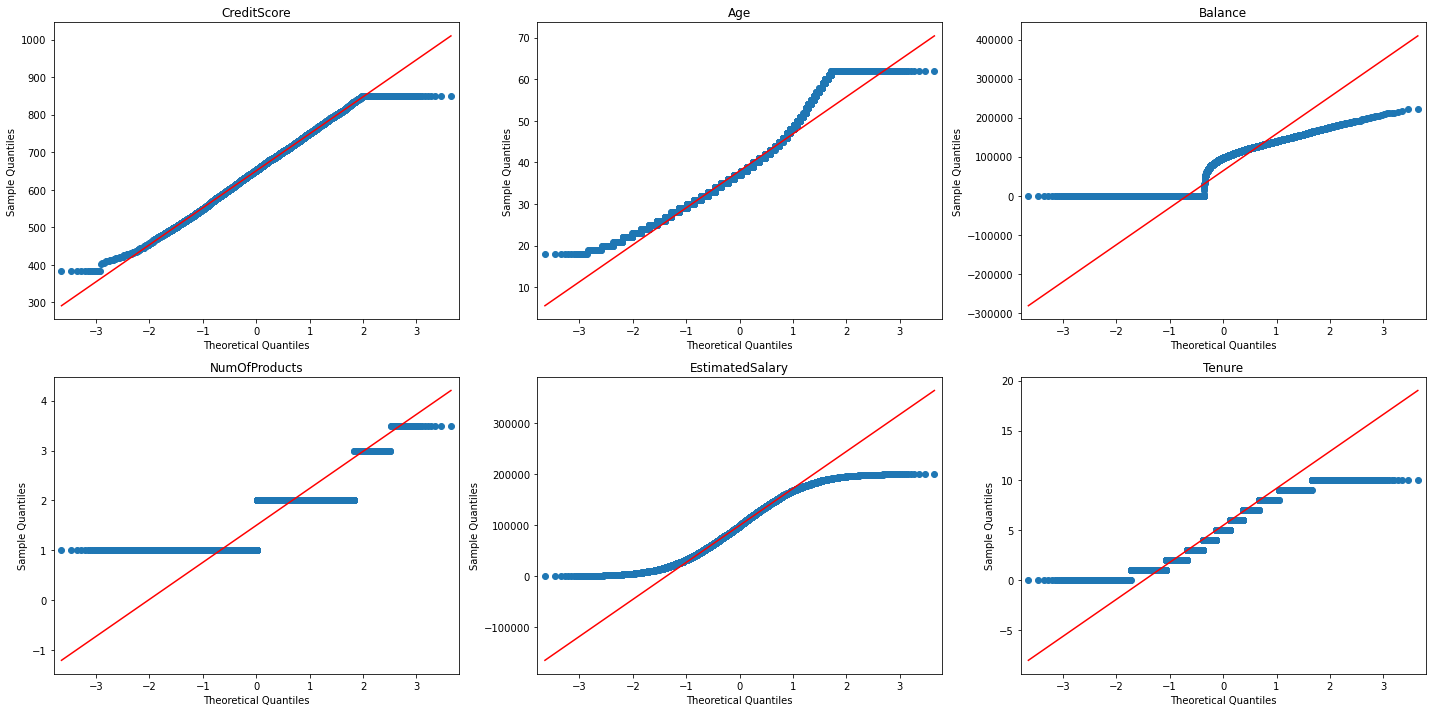

########################################################################################################
############################################## NORMALITY ###############################################
// shapiro threshold: 0.001
* W_Statistic=0.993, p=0.02880116
  CreditScore looks like gaussian (fail to reject H0)
* W_Statistic=0.964, p=0.00000000
  Age does not look Gaussian (reject H0)
* W_Statistic=0.837, p=0.00000000
  Balance does not look Gaussian (reject H0)
* W_Statistic=0.706, p=0.00000000
  NumOfProducts does not look Gaussian (reject H0)
* W_Statistic=0.959, p=0.00000000
  EstimatedSalary does not look Gaussian (reject H0)
* W_Statistic=0.955, p=0.00000000
  Tenure does not look Gaussian (reject H0)
* Number of features needs min_max = 5, std = 1 according to shapiro-test.
// features scaled with min_max: ['Age', 'Balance', 'NumOfProducts', 'EstimatedSalary', 'Tenure']
// features scaled with std: ['CreditScore']
####################################################

In [18]:
# categorical columns
label_enc = ['Gender']
onehot_enc = ['Geography']

# invoke preprocessing function
X_train_preprocessed, X_val_preprocessed = data_preprocessing(X_train, y_train, X_val, y_val, label_enc, onehot_enc, 
                                                              out_threshold=1.5, shapiro_threshold=.001)

### `4.2` LogisticRegression Model

In [19]:
log_model = LogisticRegression(max_iter=100, fit_intercept=True)
log_model.fit(X_train_preprocessed, y_train)
evaluate_logistic_model(y_val, X_val_preprocessed, log_model)

                  predicted_not-churn  predicted_churn
actual_not-churn                 1931               60
actual_churn                      424               85


,precision_churn,recall_churn,f1_churn,precision_not_churn,recall_not_churn,f1_not_churn
0,0.586207,0.166994,0.259939,0.819958,0.969864,0.888633


#### Code from labs (to meet business requirments 75%)

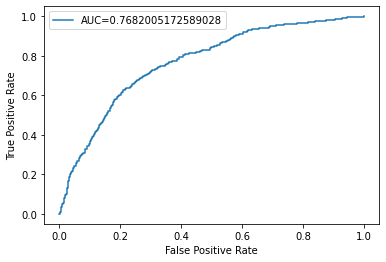

In [20]:
y_pred_proba = log_model.predict_proba(X_val_preprocessed)[:, 1]
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)
auc = roc_auc_score(y_val, y_pred_proba)

#create ROC curve showing in the bottom the AUC curve
plt.plot(fpr, tpr, label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()

In [21]:
y_pred_after_threshold = np.where(y_pred_proba<=thresholds[np.where(tpr >= 0.75)[0][0]], 0, 1)
evaluate_logistic_model(y_val, X_val_preprocessed, log_model, y_pred_after_threshold, False)

                  predicted_not-churn  predicted_churn
actual_not-churn                 1312              679
actual_churn                      128              381


,precision_churn,recall_churn,f1_churn,precision_not_churn,recall_not_churn,f1_not_churn
0,0.359434,0.748527,0.48566,0.911111,0.658965,0.764792


In [22]:
print(f"* Number of predicted churn with logistic: {(y_pred_after_threshold==1).sum()}")

* Number of predicted churn with logistic: 1060


### `4.3` SVC Model

In [23]:
# initialize our list of hyper-parameters to be tested
Cs = [0.01, 0.1, 0.5, 3, 4, 10]
Gs = [0.001, 0.01, 0.1, 1, 10]
Ds = [1, 2, 3, 4, 5]
Coef0s = [0.2, 0.5, 0.8, 2, 3]

#### `4.3.1` SVC Linear Kernel

In [24]:
linear_models = []
for c in Cs:
    model = create_svc_model(X_train_preprocessed, y_train, 'linear', c=c)
    linear_models.append(model)
    
linear_metrics = evaluate_models(y_val, X_val_preprocessed, linear_models, 'linear')
linear_metrics.sort_values(by=['recall_churn'], ascending=False).head(3)

,C,precision_churn,recall_churn,f1_churn,precision_not_churn,recall_not_churn,f1_not_churn
5,10.0,0.399546,0.691552,0.506475,0.903027,0.734304,0.809972
3,3.0,0.398180,0.687623,0.504323,0.901912,0.734304,0.809524
4,4.0,0.398180,0.687623,0.504323,0.901912,0.734304,0.809524


#### `4.3.2` SVC Poly Kernel

In [25]:
poly_models = []
for c in Cs:
    for d in Ds:
        for c0 in Coef0s:
            model = create_svc_model(X_train_preprocessed, y_train, 'poly', c=c, d=d, coef0=c0)
            poly_models.append(model)
            
poly_metrics = evaluate_models(y_val, X_val_preprocessed, poly_models, 'poly')
poly_metrics.sort_values(by=['recall_churn'], ascending=False).head(3)

,C,degree,Coef0,precision_churn,recall_churn,f1_score_churn,precision_not_churn,recall_not_churn,f1_score_not_churn
89,3.0,3,3.0,0.438654,0.793713,0.565035,0.933502,0.740331,0.825770
135,10.0,3,0.2,0.445183,0.789784,0.569405,0.932999,0.748368,0.830546
138,10.0,3,2.0,0.445183,0.789784,0.569405,0.932999,0.748368,0.830546


In [26]:
# trade off between recall and precision => model 74
poly_metrics[poly_metrics['recall_churn']>0.75].sort_values(by=['precision_churn'], ascending=False).head(3)

,C,degree,Coef0,precision_churn,recall_churn,f1_score_churn,precision_not_churn,recall_not_churn,f1_score_not_churn
119,4.0,4,3.0,0.467626,0.766208,0.580789,0.928571,0.776996,0.846049
61,0.5,3,0.5,0.467233,0.756385,0.577644,0.926014,0.779508,0.846469
94,3.0,4,3.0,0.467145,0.768173,0.580981,0.929044,0.775992,0.845649


In [33]:
print(f"* Number of predicted churn with polynomial kernel: {(poly_models[119].predict(X_val_preprocessed)==1).sum()}")

* Number of predicted churn with polynomial kernel: 834


#### `4.3.2` SVC RBF Kernel

In [28]:
rbf_models = []
for c in Cs:
    for g in Gs:
        model = create_svc_model(X_train_preprocessed, y_train, 'rbf', c=c, gamma=g)
        rbf_models.append(model)

rbf_metrics_train = evaluate_models(y_train, X_train_preprocessed, rbf_models, 'rbf')
rbf_metrics_val = evaluate_models(y_val, X_val_preprocessed, rbf_models, 'rbf')
rbf_metrics_val.sort_values(by=['recall_churn'], ascending=False).head(3)

,C,gamma,precision_churn,recall_churn,f1_churn,precision_not_churn,recall_not_churn,f1_not_churn
27,10.0,0.1,0.471084,0.768173,0.584018,0.929341,0.779508,0.847856
13,0.5,1.0,0.432768,0.752456,0.549498,0.921981,0.747865,0.825846
17,3.0,0.1,0.442509,0.748527,0.556204,0.921904,0.758915,0.832507


In [29]:
# trade off between recall and precision model => 27
rbf_metrics_val[rbf_metrics_val['recall_churn']>0.75].sort_values(by=['precision_churn'], ascending=False).head(3)

,C,gamma,precision_churn,recall_churn,f1_churn,precision_not_churn,recall_not_churn,f1_not_churn
27,10.0,0.1,0.471084,0.768173,0.584018,0.929341,0.779508,0.847856
13,0.5,1.0,0.432768,0.752456,0.549498,0.921981,0.747865,0.825846


In [30]:
print(f"* Number of predicted churn with rbf kernel: {(rbf_models[27].predict(X_val_preprocessed)==1).sum()}")

* Number of predicted churn with rbf kernel: 830


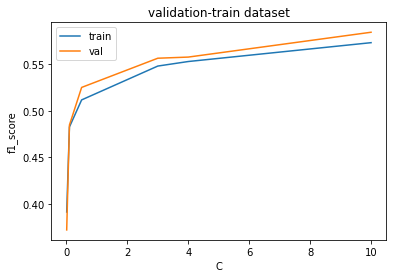

In [31]:
# plotting C vs f1_score (validation/train dataset)
plt.plot(rbf_metrics_train[rbf_metrics_train['gamma']==0.1]['C'], 
         rbf_metrics_train[rbf_metrics_train['gamma']==0.1]['f1_churn'], label='train')

plt.plot(rbf_metrics_val[rbf_metrics_val['gamma']==0.1]['C'], 
         rbf_metrics_val[rbf_metrics_val['gamma']==0.1]['f1_churn'], label='val')

plt.title('validation-train dataset')
plt.xlabel('C')
plt.ylabel('f1_score')
plt.legend()
plt.show()

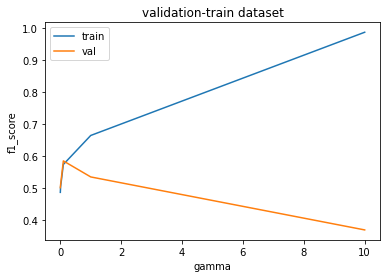

In [32]:
# plotting gamma vs f1_score (validation/train dataset)
plt.plot(rbf_metrics_train[rbf_metrics_train['C']==10]['gamma'], 
         rbf_metrics_train[rbf_metrics_train['C']==10]['f1_churn'], label='train')

plt.plot(rbf_metrics_val[rbf_metrics_val['C']==10]['gamma'], 
         rbf_metrics_val[rbf_metrics_val['C']==10]['f1_churn'], label='val')

plt.title('validation-train dataset')
plt.xlabel('gamma')
plt.ylabel('f1_score')
plt.legend()
plt.show()

# CONCLUSION FOR SVC
According to precision and recall trade off i choosed the RBF model because, it satisfy all the requriments

|  C  | gamma | coef0 | degree |  Prec  |  Recal |   F1   | Kernel | predicted_churn |
|:---:|:-----:|:-----:|:------:|:------:|:------:|:------:|:------:|:---------------:|
|  10 |  0.1  |   --  |   --   | 0.4710 | 0.7681 | 0.5840 |   RBF  |       830       |
| 4.0 |   --  |   3   |    4   | 0.4676 | 0.7662 | 0.5807 |  Poly  |       834       |

# LOGISTIC VS SVC
Here I also choosed the RBF model because, it satisfy all the requriments with higher percision and recall

|  C  | gamma | coef0 | degree |  Prec  |  Recal |   F1   |   Model  | predicted_churn |
|:---:|:-----:|:-----:|:------:|:------:|:------:|:------:|:--------:|:---------------:|
|  -- |   --  |   --  |   --   | 0.3590 | 0.7485 | 0.4853 | Logistic |       1060      |
|  10 |  0.1  |   --  |   --   | 0.4710 | 0.7662 | 0.5840 |    RBF   |       830       |